In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
from pandas.tseries import offsets
import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullLocator)
import matplotlib.dates as mdates

We reviewed four different sources of records relating to segregation placements at the Northwest ICE Processing Center/Northwest Detention Center (NWIPC/NWDC). These include two internal datasets created by GEO Group or its employees; and two installments of data from ICE’s Segregation Review Management System (SRMS). We detail each of these sources in turn below.

The NWDC segregation datasets created by GEO Group were obtained from ICE via our ongoing FOIA lawsuit; we believe it is the first time that such internal records have been made publicly available. The first of these, with the original filename `Sep_1_2013_to_March_31_2020_SMU_geotrack_report_Redacted.pdf`, is described by US DOJ attorneys for ICE as follows:

> “The GEOtrack report that was provided to Plaintiffs runs from September 1, 2013 to March 31, 2020.  That report not only reports all placements into segregation, but it also tracks movement.  This means that if an individual is placed into one particular unit then simply moves to a different unit, it is tracked in that report (if an individual is moved from H unit cell 101 to H unit cell 102, it would reflect the move as a new placement on the report).”

We refer to this report here by the shorthand "SMU" for "Special Management Unit".

The second internal dataset, with the original filename `15_16_17_18_19_20_RHU_admission_Redacted.xlsx`, is described by US DOJ attorneys for ICE as follows:

> “The [RHU] spreadsheet runs from January 2015 to May 28, 2020 and was created by and for a lieutenant within the facility once he took over the segregation lieutenant duties. The spreadsheet is updated once a detainee departs segregation. The subjects who are included on this list, therefore, are those who were placed into segregation and have already been released from segregation. It does not include those individuals who are currently in segregation.”

We refer to this report here by the shorthand "RHU" for "Restricted Housing Unit". (US DOJ attorneys for ICE specified that the terms “Special Management Unit” and “Restricted Housing Unit” are interchangeable and identify the same locations.)

# GEOtrack report (SMU)

Original filename: `Sep_1_2013_to_March_31_2020_SMU_geotrack_report_Redacted.pdf`

The original file has been converted from PDF to CSV format using the [Xpdf pdftotext](https://www.xpdfreader.com/pdftotext-man.html) command line tool with `--table` option, and hand cleaned to correct OCR errors. The resulting CSV has been minimally cleaned in a separate process dropping 14 duplicated records and adding unique identifier field `hashid`; cleaning code availabe upon request.

The original file includes three redacted fields: `Alien #`, `Name`, and `Birthdate`. The file appears to be generated by a database report for the date range "9/1/2013 To 3/31/2020", presumably from the "GEOTrack" database referenced in the filename and by the DOJ attorneys for ICE.

In [397]:
smu = pd.read_csv('../input/smu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [398]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,hashid
0,GUATEMALA,H-NA-108,6/27/2013 1:31:00AM,4/9/2014 11:49:00PM,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM,5959182d61619f9f19d9649e652e7645c4456102
1,MEXICO,H-NA-205,8/5/2013 2:30:00PM,11/10/2014 6:34:00AM,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM,098a6ee8b28d3d538836254eaa31bce18de55e29
2,MEXICO,H-NA-106,8/8/2013 10:08:00AM,9/6/2013 11:41:00AM,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM,78856b6ebe6b22232bde8e34b08f7d354aca27e5
3,MARSHALL ISLANDS,H-NA-203,8/15/2013 11:17:00AM,9/13/2013 9:05:00AM,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM,a082a6e4a9178d87640302f7117618b6d7d0d25d
4,MEXICO,H-NA-209,8/15/2013 10:07:00PM,9/9/2013 12:00:00AM,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM,b83d2d7fb1b5a838e873d3926d4df75bdf82c813


In [399]:
len(smu)

3433

All dates convert successfully:

In [400]:
assert pd.to_datetime(smu['assigned_dt'], errors='coerce').isnull().sum() == 0
smu['assigned_dt'] = pd.to_datetime(smu['assigned_dt'])
assert pd.to_datetime(smu['removed_dt'], errors='coerce').isnull().sum() == 0
smu['removed_dt'] = pd.to_datetime(smu['removed_dt'])

In [401]:
smu[smu.duplicated(keep=False)]

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,hashid


Validating date fields: One record has a `removed_dt` value less than `assigned_dt`, but this is only a discrepancy in the hour values:

In [402]:
sum(smu['assigned_dt'] > smu['removed_dt'])

1

In [403]:
smu.loc[smu['assigned_dt'] > smu['removed_dt']]

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,hashid
3432,MEXICO,H-NA-110,2020-03-31 18:28:00,2020-03-31 12:00:00,0,3/31/2020,6:28:00PM,3/31/2020,12:00:00PM,cf3462b01a21b663dbc39a4436a9e575a88dff66


95 records have a `removed_dt` value equal to `assigned_dt`:

In [404]:
sum(smu['assigned_dt'] == smu['removed_dt'])

81

In [405]:
smu.loc[smu['assigned_dt'] == smu['removed_dt']].head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,hashid
55,MEXICO,H-NA-209,2013-09-22 03:25:00,2013-09-22 03:25:00,0,9/22/2013,3:25:00AM,9/22/2013,3:25:00AM,a9a6de7c3ff45aa2328a691f0e828415f70665e6
57,MEXICO,H-NA-209,2013-09-22 03:29:00,2013-09-22 03:29:00,0,9/22/2013,3:29:00AM,9/22/2013,3:29:00AM,ba1a1ea5084b789cba09063287c39bdf8245209d
145,UKRAINE,H-NA-210,2013-11-08 03:30:00,2013-11-08 03:30:00,0,11/8/2013,3:30:00AM,11/8/2013,3:30:00AM,e0cc37fe901c55d50cc67a54484c4a82a956190c
190,MOROCCO,H-NA-103,2013-11-29 02:11:00,2013-11-29 02:11:00,0,11/29/2013,2:11:00AM,11/29/2013,2:11:00AM,6acdb83121e6ce2925e71f9f2988d9aa825157e1
253,LAOS,H-NA-102,2013-12-28 20:03:00,2013-12-28 20:03:00,0,12/28/2013,8:03:00PM,12/28/2013,8:03:00PM,6a9070d7313cf40dfe0739d6f7e7c5b896849995


Recalculating segregation placement length based on date only results in same value as `days_in_seg` field.

Note that this calculation is not first day inclusive, as in the case of the RHU dataset and SRMS datasets below. We will discard hourly data and calculate first day inclusive stay lengths below for comparison purposes.

In [406]:
smu['days_calc'] = (pd.to_datetime(smu['removed_date']) - pd.to_datetime(smu['assigned_date'])) / np.timedelta64(1, 'D')
assert sum(smu['days_in_seg'] == smu['days_calc']) == len(smu)

In [407]:
smu['days_calc'].describe()

count    3433.000000
mean        9.976697
std        23.672531
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       488.000000
Name: days_calc, dtype: float64

About 16% of records reflect stay lengths of less than one day, based on placement dates.

In [408]:
sum(smu['days_calc'] < 1)

547

In [409]:
sum(smu['days_calc'] < 1) / len(smu)

0.15933585785027674

Calculating hourly segregation placement length based on datetime field gives us slightly different values; but we should discard hourly data because it is not available in other datasets for comparison, and it is unreliable as seen above.

In [410]:
smu['hours_calc'] = (smu['removed_dt'] - smu['assigned_dt']) /  np.timedelta64(1, 'h')

In [411]:
smu['hours_calc'].describe()

count     3433.000000
mean       239.705088
std        567.542967
min         -6.466667
25%         26.050000
50%         81.250000
75%        233.066667
max      11710.366667
Name: hours_calc, dtype: float64

In [412]:
sum(smu['hours_calc'] < 24)

818

GEOTrack database export timeframe appears to be based on `removed_dt` min/max values:

In [413]:
print(smu['assigned_dt'].describe(), sep='\n')

count                    3433
unique                   3297
top       2020-02-28 04:29:00
freq                        3
first     2013-06-27 01:31:00
last      2020-03-31 18:28:00
Name: assigned_dt, dtype: object


In [414]:
smu['removed_dt'].describe()

count                    3433
unique                   3303
top       2020-03-31 12:00:00
freq                       17
first     2013-09-01 18:18:00
last      2020-03-31 12:00:00
Name: removed_dt, dtype: object

In [415]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].median()

assigned_dt
2013-01-01    3.0
2014-01-01    3.0
2015-01-01    3.0
2016-01-01    3.0
2017-01-01    4.0
2018-01-01    5.0
2019-01-01    4.0
2020-01-01    2.0
Freq: AS-JAN, Name: days_calc, dtype: float64

In [416]:
print(smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].mean())

assigned_dt
2013-01-01    10.785185
2014-01-01     7.831721
2015-01-01     9.393814
2016-01-01     9.889693
2017-01-01    12.404537
2018-01-01    11.188940
2019-01-01     9.501969
2020-01-01     7.437956
Freq: AS-JAN, Name: days_calc, dtype: float64


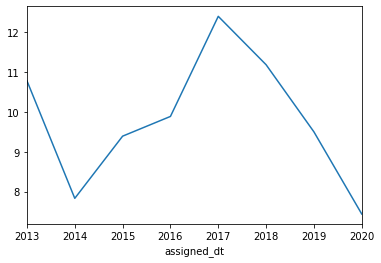

In [417]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].mean().plot()

In [418]:
assert sum(smu['citizenship'].isnull()) == 0
smu_annual = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()

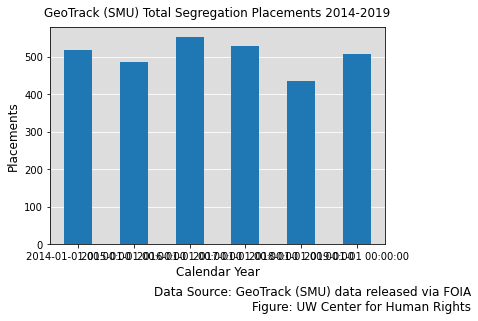

In [419]:
data = smu.set_index('assigned_dt').loc['2014':'2019']
data = data.groupby([pd.Grouper(freq='AS')])['citizenship'].count()

fig, ax = plt.subplots()

data.plot(kind='bar')

data.index = [f'{x.year}' for x in data.index]

ax.set_facecolor('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(color='#FFFFFF')

plt.title('GeoTrack (SMU) Total Segregation Placements 2014-2019', fontsize=12, pad=10)
plt.ylabel('Placements', fontsize=12)
plt.xlabel('Calendar Year', fontsize=12)
plt.xticks(rotation=0)

txt='Data Source: GeoTrack (SMU) data released via FOIA\nFigure: UW Center for Human Rights'
plt.figtext(1.1, -.1, txt, wrap=True, horizontalalignment='right', fontsize=12)

plt.show();

In [420]:
smu_annual

assigned_dt
2013-01-01    270
2014-01-01    517
2015-01-01    485
2016-01-01    553
2017-01-01    529
2018-01-01    434
2019-01-01    508
2020-01-01    137
Freq: AS-JAN, Name: citizenship, dtype: int64

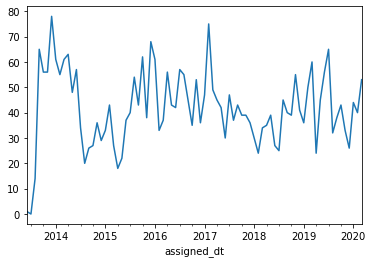

In [421]:
smu_monthly = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='M')])['citizenship'].count()
smu_monthly.plot()

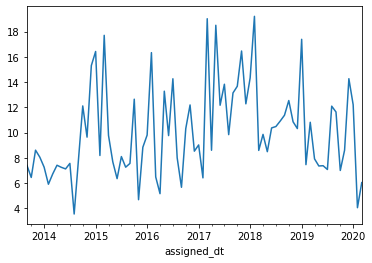

In [422]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].mean().plot()

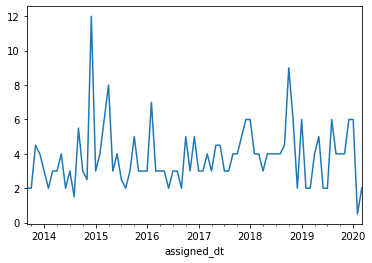

In [423]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].median().plot()

Stays over 14 days must be reported to ICE SRMS. Flagging long placements and calculating as percent of total placements. (Caveat: placements are by housing assignment, not cumulative stay length, so long stays are likely undercounted here.)

In [424]:
smu['long_stay'] = smu['days_calc'] > 14

In [425]:
long_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['long_stay'].sum()

In [426]:
count_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()

Long stays are increasing over time both absolutely and as proportion of total placements:

In [427]:
(long_g / count_g * 100)

assigned_dt
2013-01-01    17.777778
2014-01-01    12.765957
2015-01-01    12.989691
2016-01-01    15.370705
2017-01-01    17.769376
2018-01-01    24.193548
2019-01-01    21.850394
2020-01-01    18.978102
Freq: AS-JAN, dtype: float64

In [428]:
long_g

assigned_dt
2013-01-01     48.0
2014-01-01     66.0
2015-01-01     63.0
2016-01-01     85.0
2017-01-01     94.0
2018-01-01    105.0
2019-01-01    111.0
2020-01-01     26.0
Freq: AS-JAN, Name: long_stay, dtype: float64

In [429]:
count_g

assigned_dt
2013-01-01    270
2014-01-01    517
2015-01-01    485
2016-01-01    553
2017-01-01    529
2018-01-01    434
2019-01-01    508
2020-01-01    137
Freq: AS-JAN, Name: citizenship, dtype: int64

A [June 24-26, 2014 DHS inspection report](https://drive.google.com/file/d/1YDX4fOOJ3DCftWiQv7O_5jwA2eZ0ftWR/view?usp=sharing) for NWDC states, “Documentation reflects there were 776 assignments to segregation in the past year”. The SMU dataset covers this period, albeit with only partial records for June-Sept 2013. Total count of placements during this period is reasonably close to figure cited by DHS inspectors, which suggests an average of just over 60 placements per month. 

In [307]:
776 / 12

64.66666666666667

In [308]:
smu.set_index('assigned_dt').loc[:'2014-06-30'].groupby(pd.Grouper(freq='M'))['citizenship'].count()

assigned_dt
2013-06-30     1
2013-07-31     0
2013-08-31    14
2013-09-30    65
2013-10-31    56
2013-11-30    56
2013-12-31    78
2014-01-31    61
2014-02-28    55
2014-03-31    61
2014-04-30    63
2014-05-31    48
2014-06-30    57
Freq: M, Name: citizenship, dtype: int64

In [309]:
smu.set_index('assigned_dt').loc['2013-09-01':'2014-06-30'].groupby(pd.Grouper(freq='M'))['citizenship'].count().mean()

60.0

In [310]:
smu['assigned_dt'].min()

Timestamp('2013-06-27 01:31:00')

In [311]:
smu['removed_dt'].min()

Timestamp('2013-09-01 18:18:00')

In [312]:
len(smu.set_index('assigned_dt').loc[:'2014-06-30'])

615

In [313]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,hashid,days_calc,hours_calc,long_stay
0,GUATEMALA,H-NA-108,2013-06-27 01:31:00,2014-04-09 23:49:00,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM,5959182d61619f9f19d9649e652e7645c4456102,286.0,6886.300000,True
1,MEXICO,H-NA-205,2013-08-05 14:30:00,2014-11-10 06:34:00,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM,098a6ee8b28d3d538836254eaa31bce18de55e29,462.0,11080.066667,True
2,MEXICO,H-NA-106,2013-08-08 10:08:00,2013-09-06 11:41:00,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM,78856b6ebe6b22232bde8e34b08f7d354aca27e5,29.0,697.550000,True
3,MARSHALL ISLANDS,H-NA-203,2013-08-15 11:17:00,2013-09-13 09:05:00,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM,a082a6e4a9178d87640302f7117618b6d7d0d25d,29.0,693.800000,True
4,MEXICO,H-NA-209,2013-08-15 22:07:00,2013-09-09 00:00:00,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM,b83d2d7fb1b5a838e873d3926d4df75bdf82c813,25.0,577.883333,True


In [314]:
len(smu['housing'].unique())

20

In [315]:
smu.set_index('assigned_dt').groupby(pd.Grouper(freq='AS'))['housing'].nunique()

assigned_dt
2013-01-01    20
2014-01-01    20
2015-01-01    20
2016-01-01    20
2017-01-01    20
2018-01-01    20
2019-01-01    20
2020-01-01    20
Freq: AS-JAN, Name: housing, dtype: int64

In [316]:
smu['housing'].value_counts()

H-NA-107    245
H-NA-104    242
H-NA-101    241
H-NA-103    237
H-NA-102    233
H-NA-109    228
H-NA-105    228
H-NA-110    211
H-NA-106    210
H-NA-108    209
H-NA-210    156
H-NA-208    139
H-NA-209    130
H-NA-203    130
H-NA-204    125
H-NA-202    123
H-NA-201    121
H-NA-207     99
H-NA-206     74
H-NA-205     52
Name: housing, dtype: int64

# RHU

Original file: `15_16_17_18_19_20_RHU_admission_Redacted.xlsx`

Log created and maintained by hand by GEO employee to track Restricted Housing Unit placements. Described by US DOJ attorneys for ICE as follows:

> “The [RHU] spreadsheet runs from January 2015 to May 28, 2020 and was created by and for a lieutenant within the facility once he took over the segregation lieutenant duties. The spreadsheet is updated once a detainee departs segregation. The subjects who are included on this list, therefore, are those who were placed into segregation and have already been released from segregation. It does not include those individuals who are currently in segregation.”

## Dates and total days calculation

Inspection of the original Excel file suggests that the `Total days` column values are incorrect throughout, based on a broken cell formula. For example, on the "2020" spreadsheet tab, the `Total days` column values are integers which only occasionally align with calculated placement length based on the `Date in` and `Date out` columns. However, additional spreadsheet rows at the bottom of the sheet not containing values in other fields contain an Excel formula ("=(D138-C138)+1") which should have been used to calculate these values. Comparing calculated stay lengths with reported `Total days` suggests that this formula was not updated consistently, causing fields to become misaligned. Additionally, the "2015" spreadsheet tab includes many `Total days` values equal to "1", suggesting that the formula was applied incorrectly or with missing data.

We can recalculate actual stay lengths based on the formula cited above (including start days, with stays of less than one day calculated as "1"); or with the formula used for the "SMU" records above (excluding start days, with  stays of less than one day calculated as "0"), for more consistent comparison with other datasets.

The above issue raises the possibility that other fields in addition to `Total days` may be misaligned in the original dataset. One fact mitigating this possibility is that no `Date out` values predate associated `Date in` values. We can also look more closely at qualitative fields to make an educated guess as to the data quality: for example, do `intial_placement` values suggesting disciplinary placements align with `placement_reason` values also consistent with disciplinary placements? However, we do not intend to use this dataset for detailed qualitative analysis; of most interest are total segregation placements and segregation stay lengths.

In [317]:
rhu = pd.read_csv('../input/rhu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [318]:
rhu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               2457 non-null   object
 1   alien_#            2457 non-null   object
 2   date_in            2457 non-null   object
 3   date_out           2457 non-null   object
 4   total_days         2457 non-null   int64 
 5   initial_placement  2457 non-null   object
 6   placement_reason   2457 non-null   object
 7   disc_seg           2457 non-null   object
 8   release_reason     2457 non-null   object
 9   hashid             2457 non-null   object
dtypes: int64(1), object(9)
memory usage: 192.1+ KB


In [319]:
rhu.head()

,name,alien_#,date_in,date_out,total_days,initial_placement,placement_reason,disc_seg,release_reason,hashid
0,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/3/2015,1/5/2015,20,pending hearing,refusing staff orders,N,release to gen pop,7e25a7aa306bb183b21bc65d41dd00014870ca11
1,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/10/2015,1/12/2015,294,pending hearing,assault,N,release from custody,03a3e0486c022ae7c6f3be548162509d74f0a27e
2,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/12/2015,1/16/2015,8,pending hearing,disrupting facility operations,Y,released to medical,7b9186b326222d590556d8c2462e7dfb55d1bdc6
3,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/13/2015,1/29/2015,3,pending hearing,assault,Y,release to gen pop,d9dc117def1f67fb9d03131f0ec8006748b554a0
4,"(b)(6),(b)(7)(c )","(b)(6),(b)(7)(c )",1/14/2015,2/6/2015,4,security risk,"(b)(6), (b)(7)(C), (b)(7)(E)",N,release from custody,d1b57d371b84b9301da3b4c8410a7db0988be60c


In [320]:
rhu['date_in'] = pd.to_datetime(rhu['date_in'])
rhu['date_out'] = pd.to_datetime(rhu['date_out'])

As noted above, no `date_out` values predate associated `date_in` values:

In [321]:
assert sum(rhu['date_in'] > rhu['date_out']) == 0

Here we recalculate the `total days` field based on the first day inclusive formula in the original spreadsheet ("=(D138-C138)+1"):

In [322]:
rhu['total_days_calc'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D') + 1

Less than 10% of `total_days` values match `total_days_calc`:

In [323]:
sum(rhu['total_days_calc'] == rhu['total_days']) / len(rhu) * 100

7.855107855107855

Note that the summary statistics for the original field (`total_days`) are very similar to the recalculated field (`total_days_calc`), suggesting that most values are present in the dataset but misaligned:

In [324]:
rhu['total_days'].describe()

count    2457.000000
mean       13.877900
std        37.544802
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       694.000000
Name: total_days, dtype: float64

In [325]:
rhu['total_days_calc'].describe()

count    2457.000000
mean       15.077737
std        38.142819
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       694.000000
Name: total_days_calc, dtype: float64

The symmetrical distribution of values when analyzing the difference between the fields also suggests that values are largely misaligned rather than miscalculated:

In [326]:
(rhu['total_days_calc'] - (rhu['total_days'])).describe()

count    2457.000000
mean        1.199837
std        54.102994
min      -692.000000
25%        -5.000000
50%         1.000000
75%         6.000000
max       693.000000
dtype: float64

Therefore, we will conclude that it is correct to recalculate the `total_days` field here. We will follow the first day inclusive formula suggested in the original dataset here: 

In [327]:
rhu['total_days'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D') + 1

In [328]:
rhu = rhu.drop('total_days_calc', axis=1)

In [329]:
rhu['total_days'].describe()

count    2457.000000
mean       15.077737
std        38.142819
min         1.000000
25%         3.000000
50%         5.000000
75%        12.000000
max       694.000000
Name: total_days, dtype: float64

In [330]:
assert sum(pd.isnull(rhu['name'])) == 0

In [331]:
rhu_annual = rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['name'].count()

In [332]:
rhu_monthly = rhu.set_index('date_in').groupby(pd.Grouper(freq='M'))['name'].count()

In [333]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['total_days'].mean()

date_in
2015-01-01    15.374631
2016-01-01    13.013761
2017-01-01    17.978927
2018-01-01    14.826690
2019-01-01    15.343681
2020-01-01     9.848485
Freq: AS-JAN, Name: total_days, dtype: float64

# RHU/SMU comparison

In [334]:
data = pd.concat([rhu_annual, smu_annual], axis=1)

In [335]:
data.columns = ['RHU', 'SMU']

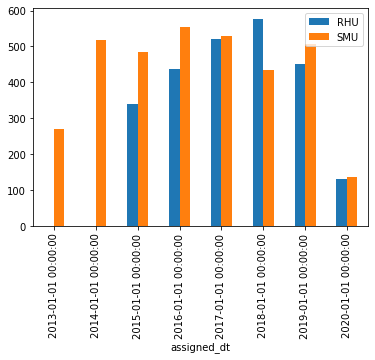

In [336]:
data.plot(kind='bar')

In [337]:
data

,RHU,SMU
assigned_dt,,
2013-01-01,NaN,270
2014-01-01,NaN,517
2015-01-01,339.0,485
2016-01-01,436.0,553
2017-01-01,522.0,529
2018-01-01,577.0,434
2019-01-01,451.0,508
2020-01-01,132.0,137


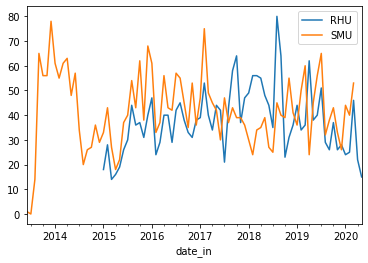

In [338]:
data = pd.concat([rhu_monthly, smu_monthly], axis=1)
data.columns = ['RHU', 'SMU']
data.plot()

The Segregation Review Management System (SRMS) datasets are maintained by ICE based on segregation placements reported under ICE's national guidelines, including placements for longer than 14 days (or 14 days during a 21-day period) and involving people with “special vulnerabilities.” UWCHR received two installments of SRMS data for NWDC: the first, released in 2019, covers the period from 2013-05-13 to 2018-05-14; the second, released in 2020, covers the period from 2013-09-03 to 2020-03-16.

The SRMS is the only available source of data for national-level analysis of segregation placements and comparisons between various detention facilities. Two investigative journalism and advocacy organizations, the International Consortium for Investigative Journalism (ICIJ) and Project On Government Oversight (POGO), have released national SRMS datasets covering different time periods.

SRMS data is examined more closely elsewhere.

# SRMS data

In [339]:
srms_1 = pd.read_csv('../input/srms-1.csv.gz', sep='|', compression='gzip')
srms_2 = pd.read_csv('../input/srms-2.csv.gz', sep='|', compression='gzip')

In [340]:
srms_1.columns

Index(['tracking_number', 'gender', 'country_of_citizenship', 'facility_aor',
       'facility', 'facility:detloc', 'report_type', 'placement_date',
       'placement_reason', 'release_date', 'length_of_stay',
       'disciplinary_infraction', 'sanction_length', 'attorney_of_record',
       'attorney_notification', 'detainee_request',
       'compliance_with_detention_standards', 'mental_illness',
       'serious_medical_illness', 'serious_disability', 'ever_smi',
       'non_compliance_detail', 'special_criteria', 'id', 'current_review',
       'created', 'lgbti', 'item_type', 'placement_reason_type',
       'admin_or_disciplinary', 'detloc', 'hashid'],
      dtype='object')

In [341]:
srms_1['placement_date'] = pd.to_datetime(srms_1['placement_date'])
srms_1['release_date'] = pd.to_datetime(srms_1['release_date'])
srms_2['placement_date'] = pd.to_datetime(srms_2['placement_date'])
srms_2['release_date'] = pd.to_datetime(srms_2['release_date'])

In [342]:
srms_1['days_calc'] = (srms_1['release_date'] - srms_1['placement_date']) / np.timedelta64(1, 'D')
srms_2['days_calc'] = (srms_2['release_date'] - srms_2['placement_date']) / np.timedelta64(1, 'D')

There are no SRMS records with placement and release on same day; this suggests comparison with first-day-inclusive calculation for stay length for SMU/RHU records.

In [343]:
srms_1['days_calc'].describe()

count    357.000000
mean      59.605042
std       88.263162
min        1.000000
25%       19.000000
50%       30.000000
75%       62.000000
max      781.000000
Name: days_calc, dtype: float64

In [344]:
srms_2['days_calc'].describe()

count    453.000000
mean      59.410596
std       77.013067
min        1.000000
25%       20.000000
50%       31.000000
75%       68.000000
max      691.000000
Name: days_calc, dtype: float64

In [345]:
srms_1_annual = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_2_annual = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_1_monthly = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()
srms_2_monthly = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()

A close review of these various datasets gives us an overview of solitary confinement practices at the NWDC, but also raises further questions about consistency of record-keeping and reporting. While the datasets are not directly comparable, and lack unique or consistent identifiers that would allow de-duplication across datasets; there are some characteristics we would expect if record-keeping and reporting was consistent:

- Between the GEO-created datasets for segregation placements at NWDC, SMU would be expected to show more and shorter placements than RHU, because it tracks specific placement locations within the NWDC.

While this is true for most years, we find that in 2018 the RHU dataset reports more total placements than SMU.

- SRMS should contain approximately the same number of long placements as SMU and RHU datasets, based on requirement to report stays longer than 14 days; plus any shorter placements involving populations with “special vulnerabilities.”

We also find that the SMU and RHU datasets include significantly more stays longer than 14 days than those reported in the SRMS datasets. This might be explained if multiple placements of the same individual tracked as multiple entries in the GEO internal reports are reported to ICE SRMS as a single entry.

Comparing total reported days for long stays, the relationship is less consistent; but either SMU or RHU always reflect more total days associated with long stays than SRMS. While not conclusive, the data is suggestive of underreporting of long solitary placements in ICE SRMS records for NWDC.

## Comparison of placement counts

In [346]:
data = pd.concat([rhu_annual, smu_annual, srms_1_annual, srms_2_annual], axis=1)

In [347]:
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']

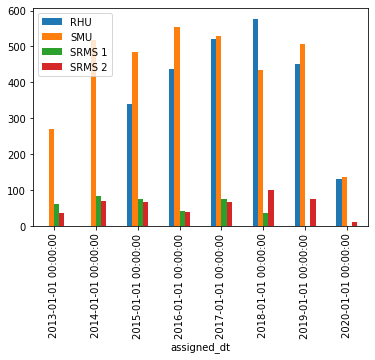

In [348]:
data.plot(kind='bar')

In [349]:
data

,RHU,SMU,SRMS 1,SRMS 2
assigned_dt,,,,
2013-01-01,NaN,270,60.0,37
2014-01-01,NaN,517,82.0,69
2015-01-01,339.0,485,76.0,66
2016-01-01,436.0,553,42.0,38
2017-01-01,522.0,529,74.0,66
2018-01-01,577.0,434,37.0,100
2019-01-01,451.0,508,NaN,75
2020-01-01,132.0,137,NaN,10


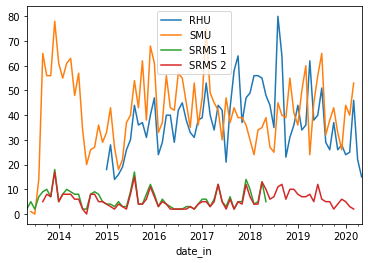

In [350]:
data = pd.concat([rhu_monthly, smu_monthly, srms_1_monthly, srms_2_monthly], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot()

In [351]:
data.loc['2015']

,RHU,SMU,SRMS 1,SRMS 2
date_in,,,,
2015-01-31,18.0,33.0,4.0,4.0
2015-02-28,28.0,43.0,4.0,3.0
2015-03-31,14.0,27.0,3.0,2.0
2015-04-30,16.0,18.0,5.0,4.0
2015-05-31,19.0,22.0,3.0,3.0
2015-06-30,26.0,37.0,3.0,2.0
2015-07-31,30.0,40.0,9.0,8.0
2015-08-31,44.0,54.0,17.0,15.0
2015-09-30,36.0,43.0,4.0,4.0


## Comparison avg. placement length over time

In [352]:
smu_mean = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['days_calc'].mean()

In [353]:
rhu_mean = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS')])['total_days'].mean()

In [354]:
srms_1_mean = srms_1.set_index('placement_date').groupby([pd.Grouper(freq='AS')])['days_calc'].mean()

In [355]:
srms_2_mean = srms_2.set_index('placement_date').groupby([pd.Grouper(freq='AS')])['days_calc'].mean()

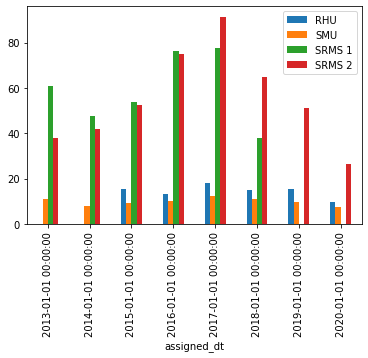

In [356]:
data = pd.concat([rhu_mean, smu_mean, srms_1_mean, srms_2_mean], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot(kind='bar')

In [357]:
data

,RHU,SMU,SRMS 1,SRMS 2
assigned_dt,,,,
2013-01-01,NaN,10.785185,60.716667,38.000000
2014-01-01,NaN,7.831721,47.609756,41.927536
2015-01-01,15.374631,9.393814,53.736842,52.515152
2016-01-01,13.013761,9.889693,76.142857,74.894737
2017-01-01,17.978927,12.404537,77.485714,91.454545
2018-01-01,14.826690,11.188940,38.000000,64.808081
2019-01-01,15.343681,9.501969,NaN,51.277778
2020-01-01,9.848485,7.437956,NaN,26.333333


# Join datasets

In [358]:
smu.columns

Index(['citizenship', 'housing', 'assigned_dt', 'removed_dt', 'days_in_seg',
       'assigned_date', 'assigned_hour', 'removed_date', 'removed_hour',
       'hashid', 'days_calc', 'hours_calc', 'long_stay'],
      dtype='object')

In [359]:
smu_ex = smu[['assigned_date', 'removed_date']].copy()
smu_ex = smu_ex.rename({'assigned_date': 'placement_date', 'removed_date': 'release_date'}, axis=1) 
smu_ex.loc[:,'placement_date'] = pd.to_datetime(smu_ex['placement_date'])
smu_ex.loc[:,'release_date'] = pd.to_datetime(smu_ex['release_date'])
smu_ex['dataset'] = 'SMU'

# First day exclusive:
smu_ex['days_calc'] = (smu_ex['release_date'] - smu_ex['placement_date']) / np.timedelta64(1, 'D')

# First day inclusive:
# smu_ex['days_calc'] = (smu_ex['release_date'] - smu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [360]:
rhu.columns

Index(['name', 'alien_#', 'date_in', 'date_out', 'total_days',
       'initial_placement', 'placement_reason', 'disc_seg', 'release_reason',
       'hashid'],
      dtype='object')

In [361]:
rhu_ex = rhu[['date_in', 'date_out']].copy()
rhu_ex = rhu_ex.rename({'date_in': 'placement_date', 'date_out': 'release_date'}, axis=1)
rhu_ex['dataset'] = 'RHU'

# First day exclusive:
rhu_ex['days_calc'] = (rhu_ex['release_date'] - rhu_ex['placement_date']) / np.timedelta64(1, 'D')

# First day inclusive:
# rhu_ex['days_calc'] = (rhu_ex['release_date'] - rhu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [362]:
srms_1.columns

Index(['tracking_number', 'gender', 'country_of_citizenship', 'facility_aor',
       'facility', 'facility:detloc', 'report_type', 'placement_date',
       'placement_reason', 'release_date', 'length_of_stay',
       'disciplinary_infraction', 'sanction_length', 'attorney_of_record',
       'attorney_notification', 'detainee_request',
       'compliance_with_detention_standards', 'mental_illness',
       'serious_medical_illness', 'serious_disability', 'ever_smi',
       'non_compliance_detail', 'special_criteria', 'id', 'current_review',
       'created', 'lgbti', 'item_type', 'placement_reason_type',
       'admin_or_disciplinary', 'detloc', 'hashid', 'days_calc'],
      dtype='object')

In [363]:
srms_1_ex = srms_1[['placement_date', 'release_date']].copy()
srms_1_ex['dataset'] = 'SRMS 1'
# SRMS datasets are already first day inclusive:
srms_1_ex['days_calc'] = (srms_1_ex['release_date'] - srms_1_ex['placement_date']) / np.timedelta64(1, 'D')

srms_2_ex = srms_2[['placement_date', 'release_date']].copy()
srms_2_ex['dataset'] = 'SRMS 2'
# SRMS datasets are already first day inclusive:
srms_2_ex['days_calc'] = (srms_2_ex['release_date'] - srms_2_ex['placement_date']) / np.timedelta64(1, 'D')

In [364]:
df = pd.concat([smu_ex, rhu_ex, srms_1_ex, srms_2_ex], axis=0)

In [365]:
df = df.dropna()

In [366]:
df['long_stay'] = df['days_calc'] > 14

In [367]:
table = pd.DataFrame()

In [368]:
table['total'] = df.groupby(['dataset'])['placement_date'].count()
table['min_date'] = df.groupby(['dataset'])['placement_date'].min()
table['max_date'] = df.groupby(['dataset'])['placement_date'].max()
table['avg_length'] = df.groupby(['dataset'])['days_calc'].mean()
table['med_length'] = df.groupby(['dataset'])['days_calc'].median()
table['min_length'] = df.groupby(['dataset'])['days_calc'].min()
table['max_length'] = df.groupby(['dataset'])['days_calc'].max()
# table['total_days'] = df.groupby(['dataset'])['days_calc'].sum()
table['total_long'] = df.groupby(['dataset'])['long_stay'].sum()
# table['pct_long'] = (df.groupby(['dataset'])['long_stay'].sum()) / (df.groupby(['dataset'])['placement_date'].count())

In [369]:
table

,total,min_date,max_date,avg_length,med_length,min_length,max_length,total_long
dataset,,,,,,,,
RHU,2457,2015-01-03,2020-05-28,14.077737,4.0,0.0,693.0,480.0
SMU,3433,2013-06-27,2020-03-31,9.976697,3.0,0.0,488.0,598.0
SRMS 1,357,2013-05-13,2018-05-14,59.605042,30.0,1.0,781.0,296.0
SRMS 2,453,2013-09-03,2020-03-16,59.410596,31.0,1.0,691.0,387.0


In [370]:
table.to_csv('../output/dataset_description.csv')

In [371]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03': '2020-03-16']

In [372]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['long_stay'].sum().unstack()

Both SMU and RHU datasets show more stays longer than 14 days than reported to SRMS during same time period (calculating first day exclusive stay lengths for SMU doesn't change this relationship):

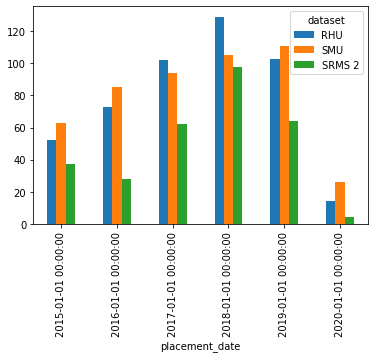

In [373]:
g.plot(kind='bar')

In [374]:
g

dataset,RHU,SMU,SRMS 2
placement_date,,,
2015-01-01,52.0,63.0,37.0
2016-01-01,73.0,85.0,28.0
2017-01-01,102.0,94.0,62.0
2018-01-01,129.0,105.0,98.0
2019-01-01,103.0,111.0,64.0
2020-01-01,14.0,26.0,4.0


In [375]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03':'2020-03-16']

In [376]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['days_calc'].sum().unstack()

Counting total days of solitary placements associated with long stays, the relationship is less consistent, but either SMU or RHU always reflect more total days associated with long stays than SRMS:

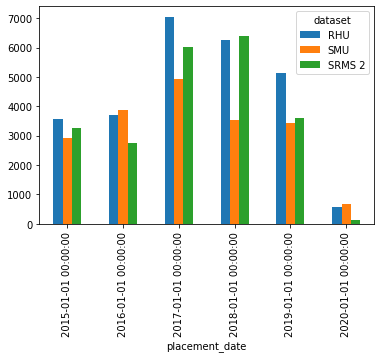

In [377]:
g.plot(kind='bar')

In [378]:
g.sum()

dataset
RHU       26252.0
SMU       19362.0
SRMS 2    22194.0
dtype: float64

In [379]:
df[df['dataset'] == 'SRMS 2'].set_index('placement_date').loc['2015-01-03':'2020-03-16']['days_calc'].sum()

22614.0

In [380]:
d = df[df['dataset'] != 'SRMS 1']
d = d.set_index('placement_date').loc['2015-01-03':'2020-03-16']

In [381]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['days_calc'].sum().unstack()

Looking at all placements including short placements, RHU and SMU usually report more total days than reported to SRMS, except during 2018 in the case of SMU:

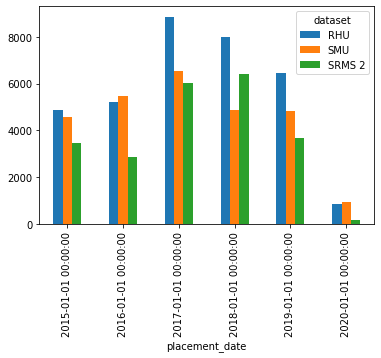

In [382]:
g.plot(kind='bar')

In [383]:
d.head()

,release_date,dataset,days_calc,long_stay
placement_date,,,,
2015-01-03,2015-01-03,SMU,0.0,False
2015-01-03,2015-01-03,SMU,0.0,False
2015-01-03,2015-01-05,SMU,2.0,False
2015-01-04,2015-02-09,SMU,36.0,True
2015-01-06,2015-01-06,SMU,0.0,False


In [384]:
d = d.reset_index()

In [385]:
d['log_days_calc'] = np.log(d['days_calc'])

/home/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [386]:
d['days_calc'].max()

693.0

/home/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


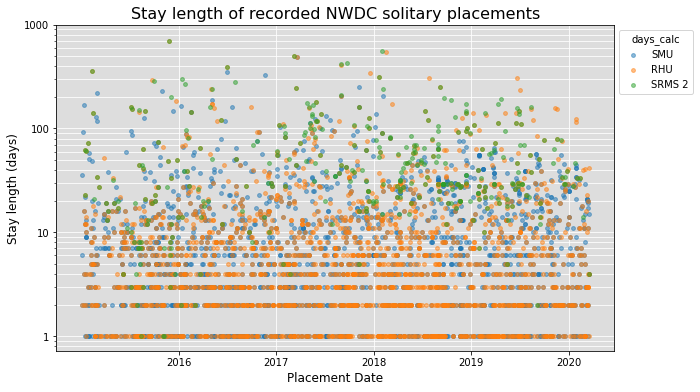

In [387]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_facecolor('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(color='#FFFFFF', which='both')
ax.xaxis.grid(color='#FFFFFF')

to_plot = 'days_calc'
values = d['dataset'].unique()

markers = ['.', '.', '.']
i = 0

for v in values:
    data = d[d['dataset'] == v]
    x=data.loc[:, 'placement_date'].astype(int)
    y=data.loc[:,'days_calc']
    plt.scatter(x, y, s=60, alpha=.5, marker=markers[i])
    i = i + 1

plt.xticks(pd.date_range(start='2015-01-03', end='2020-03-16', freq='AS').astype(int))
xticks = ax.get_xticks()
xticks_dates = [str(f'{pd.to_datetime(x).year}') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xlabel('Placement Date', fontsize=12)

plt.yscale('log')
plt.ylabel('Stay length (days)', fontsize=12)
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
plt.ylim(0, 1001)

# x_min = xticks.min()-10000000000000000
# x_max = xticks.max()+10000000000000000
# ax.hlines(14, xmin=x_min, xmax=x_max, linestyles='dashed')

plt.legend(values, title=to_plot, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Stay length of recorded NWDC solitary placements', fontsize=16)
plt.show()
plt.close(fig=fig)
del fig, ax

In [388]:
data = df[df['days_calc'] < 30]

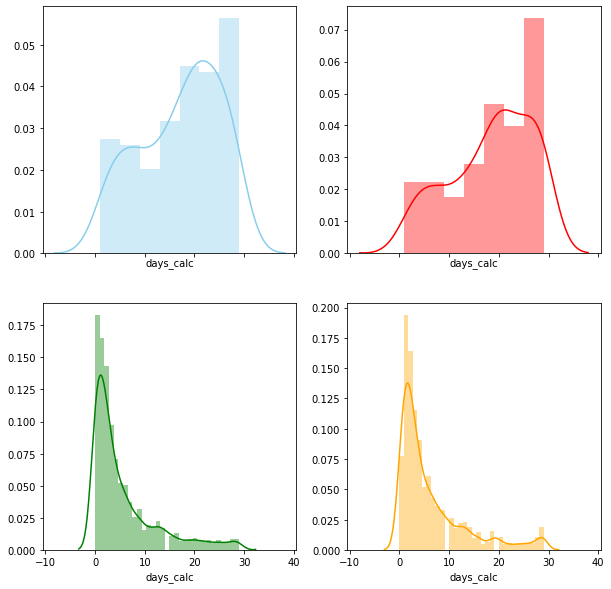

In [389]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.distplot( data.loc[data['dataset'] == 'SRMS 1',"days_calc"], norm_hist=True , color="skyblue", ax=axes[0, 0])
sns.distplot( data.loc[data['dataset'] == 'SRMS 2',"days_calc"], norm_hist=True , color="red", ax=axes[0, 1])
sns.distplot( data.loc[data['dataset'] == 'SMU',"days_calc"], norm_hist=True , color="green", ax=axes[1, 0])
sns.distplot( data.loc[data['dataset'] == 'RHU',"days_calc"], norm_hist=True , color="orange", ax=axes[1, 1])

<BarContainer object of 10 artists>

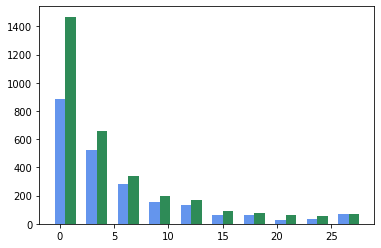

In [390]:
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(data.loc[data['dataset'] == 'RHU',"days_calc"])
b_heights, b_bins = np.histogram(data.loc[data['dataset'] == 'SMU',"days_calc"], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

In [391]:
smu['days_calc'].describe()

count    3433.000000
mean        9.976697
std        23.672531
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       488.000000
Name: days_calc, dtype: float64

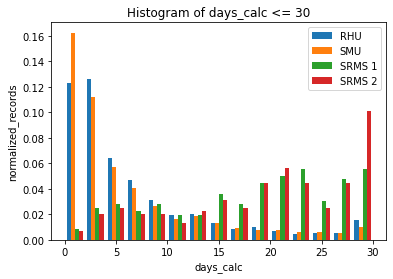

In [392]:
data = df[df['days_calc'] <= 30]

# Make a separate list for each dataset
x1 = list( data.loc[data['dataset'] == 'RHU',"days_calc"])
x2 = list( data.loc[data['dataset'] == 'SMU',"days_calc"])
x3 = list( data.loc[data['dataset'] == 'SRMS 1',"days_calc"])
x4 = list( data.loc[data['dataset'] == 'SRMS 2',"days_calc"])

# Assign colors for each dataset and the names
# colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']
names = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
         
# Make the histogram using a list of lists
# Normalize the data and assign colors and names
plt.hist([x1, x2, x3, x4], bins = int(30/2), density=True, label=names)

# Plot formatting
plt.legend()
plt.xlabel('days_calc')
plt.ylabel('normalized_records')
plt.title('Histogram of days_calc <= 30')
plt.show();

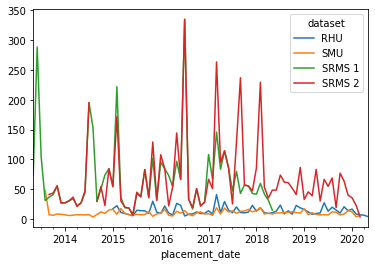

In [393]:
df.set_index('placement_date').groupby([pd.Grouper(freq='M'),'dataset'])['days_calc'].mean().unstack().plot()

In [394]:
df.set_index('placement_date').groupby([pd.Grouper(freq='Q'),'dataset'])['hashid'].nunique()

KeyError: 'Column not found: hashid'

In [ ]:
df.set_index('placement_date').groupby([pd.Grouper(freq='Q'),'dataset'])['days_calc'].median()

In [395]:
2000 * 1.1099

2219.8